Restarted social_learning (Python 3.9.18)

0 0.9983870967741936
1 0.9875078043704475
2 0.8982622268470344
3 0.7511238293444329
FJ_iters: 3

        DataSource: real_dataset
        DataFile: fb-pages-food.edges
        Random W: False
        #nodes: 620
        #articles: 3
        W_Sparse: 0.7511238293444329
        Pr(y==1): 0.5876344086021505
        P_range: (0.3, 0.9)
        Count Z<0: 503, 0.27043010752688174
        FJ_iters: 0
        repeat_exp: 1
        repeatk: 3
        
objective_random:0.03, 0.08, 0.27, 0.28, 0.31, 0.33, 0.35, 0.40, 0.41, 0.43, 0.45, 0.50, 0.52, 0.52, 0.54, 0.55, 0.57, 0.59, 0.59, 0.60, 0.60, 0.61, 0.61, 0.63, 0.66, 0.67, 0.68, 0.68, 0.68, 0.69, 0.70, 0.70, 0.74, 0.74, 0.74, 0.74, 0.76, 0.77, 0.79, 0.79, 0.79, 0.79, 0.81, 0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.83, 0.83, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.85, 0.85, 0.85, 0.86, 0.86, 0.86, 0.87, 0.87, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.90, 0.90, 0.90, 0.90, 0.90, 0.90, 

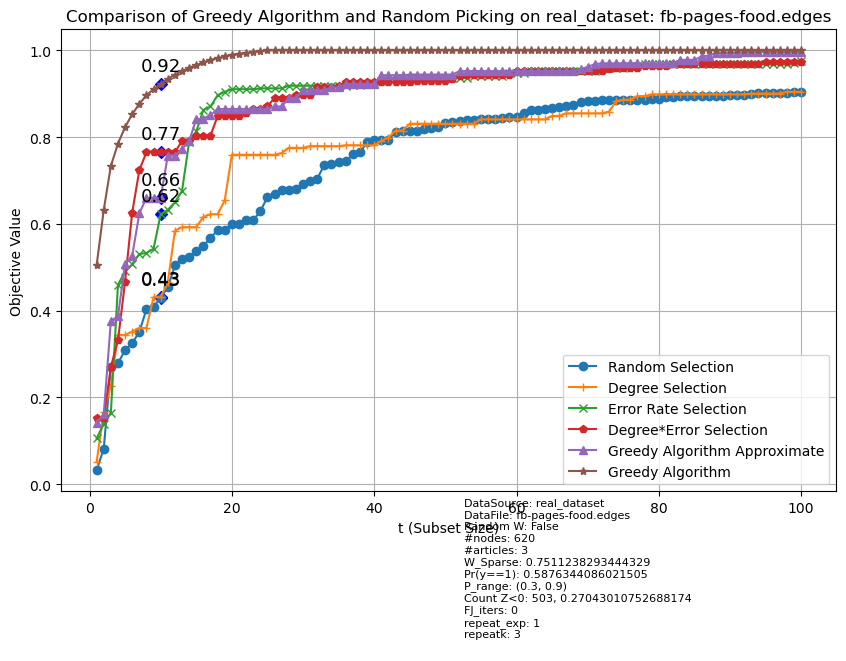

Avg#Selection==>0.5:	 [[11. 11.  5.  5.  4.  0.]],
Avg#Selection==>0.6:	 [[19. 15.  9.  5.  6.  1.]],
Avg#Selection==>0.7:	 [[31. 19. 13.  6. 10.  2.]],
Avg#Selection==>0.8:	 [[42. 42. 14. 14. 14.  4.]],
Avg#Selection==>0.9:	 [[93. 92. 18. 31. 29.  8.]],
Avg#Selection==>0.95:	 [[100. 100.  61.  59.  51.  12.]],
Avg#Selection==>0.99:	 [[100. 100. 100. 100.  87.  19.]],


In [1]:
import numpy as np
import networkx as nx
import random
import copy
import matplotlib.pyplot as plt
import math

from scipy.io import mmread
import pickle
from datetime import datetime

from utils import *
from data_loader import *

# # Create a dictionary mapping keywords to functions or objects
# switch_dict = {
#     'erdos_renyi': erdos_renyi_graph,
#     'watts_strogatz': watts_strogatz_graph,
#     'barabasi_albert': barabasi_albert_graph,
#     'real_dataset': load_real_dataset,
# }





def main():
    py_fname = "exp8_degree_"
    # n = 1024
    n=128
    # k = 10
    k=3
    rho = 0.05  # ratio of nonzeros in W
    p = 0.6 # Probability for 1 in y
    p_low = 0.3
    p_high = 0.9
    Prange=(p_low, p_high)

    randomW = True
    save_plot = True
    save_results = True
    FJ_maxiters = 3
    repeatk = 3
    FJ_iters = 0
    d=10

    datasrc = None
    file_path = ""
    max_iterations = 100
    early_stop = 0.99

    

    G=None

    # SEED=3
    repeat_exp = 1
    # algorithms_count = len(AlgorithmList)
    mask = MASK
    algorithms_count = np.sum(np.array(MASK))
    objective_vals = np.ones([algorithms_count, repeat_exp, n ]) 
    objective_reps_vals = np.ones_like(objective_vals)
    # objective_greedys, objective_greedy_appros, objective_randoms,objective_degrees = np.ones([repeat_exp, n]), np.ones([repeat_exp, n]), np.ones([repeat_exp, n]), np.ones([repeat_exp, n])
    max_total_iterations = 0
    for i in range(repeat_exp):
        SEED = i
        random.seed(SEED)
        np.random.seed(SEED)
        
        ### random generated graphs
        # datasrc = "erdos_renyi"
        # W = select_model_or_dataset(datasource=datasrc, n=n, p=0.005, seed=SEED, directed=False, FJ_maxiters=FJ_maxiters)

        # datasrc = "barabasi_albert"
        # W = select_model_or_dataset(datasource=datasrc, n=n, m=5, seed=SEED)

        # datasrc = "watts_strogatz"
        # W = select_model_or_dataset(datasrc, n=n, k=5, p=0.25, FJ_maxiters=FJ_maxiters, seed=SEED)

        # datasrc = "random_W"
        # W = select_model_or_dataset(datasource=datasrc, n=n, rho=rho)

        ### real graph datasets
        datasrc = "real_dataset"
        data_filenames = ['chesapeake.mtx', 'bio-celegansneural.mtx', 'delaunay_n10.mtx', 'polblogs.mtx', "soc-wiki-Vote.mtx", "fb-pages-food.edges.edges", "soc-hamsterster.edges"]
        file_path = 'fb-pages-food.edges'
        delimiter = ' '
        if file_path  == 'fb-pages-food.edges':
            delimiter=','
        W = select_model_or_dataset(datasource=datasrc, FJ_maxiters=FJ_maxiters, file_path=file_path, delimiter=delimiter)

        randomW = (datasrc == "random_W")

        n = W.shape[0]
        # Y = initialize_y(n, k, p)
        Y = initialize_y_with_randomP(n, k, Prange=Prange, seed=SEED)
        Z = W @ Y
        m = np.sum(Z < 0)
        d = math.ceil(math.log2(n))

        # print("datasource:\t",  datasrc)
        # print("number of nodes:\t", n)
        # print("number of articles:\t", k)
        # print("sparsity factor of W:\t", rho)
        # print("probability of 1 in y:\t", p)

        # print("Number of negative elements in Z: ", m)

        # Meta information
        meta_info = f"""
        DataSource: {datasrc}
        DataFile: {file_path}
        Random W: {randomW}
        #nodes: {Z.shape[0]}
        #articles: {Z.shape[1]}
        W_Sparse: {np.sum(W==0)/(W.size)}
        Pr(y==1): {np.sum(Y==1)/(Y.size)}
        P_range: {Prange}
        Count Z<0: {m}, {m/Z.size}
        FJ_iters: {FJ_iters}
        repeat_exp: {repeat_exp}
        repeatk: {repeatk}
        """
        print(meta_info)

        # total_iterations = 2 * int(math.sqrt(n)) + 1


        results, total_iterations =  experiment8(n, W, Y, Z, m=m, max_iterations=max_iterations, early_stop=early_stop, repeatk=repeatk, mask=mask)
        print("########========Experiment8 DONE!========########")
        print("results.shape==", results.shape, "total_its==", total_iterations)
        # objective_greedy, objective_greedy_appro, objective_random, objective_degree = results
        # print(len(objective_greedy))
        # print(len(objective_greedy_appro))
        # print(len(objective_random))
            
        # objective_greedys[i,:total_iterations]=np.array(objective_greedy)
        # objective_greedy_appros[i,:total_iterations]=np.array(objective_greedy_appro)
        # objective_randoms[i,:total_iterations]=np.array(objective_random)
        # objective_degrees[i,:total_iterations]=np.array(objective_degree)

        objective_vals[:, i, :total_iterations] = results
        if total_iterations > max_total_iterations:
            max_total_iterations = total_iterations

    # objective_greedy = np.mean(objective_greedys, axis=0)
    # objective_greedy_appro = np.mean(objective_greedy_appros, axis=0)
    # objective_random = np.mean(objective_randoms, axis=0)
    # objective_degree = np.mean(objective_degrees, axis=0)

    objective_reps_vals = objective_vals[:, :, :max_total_iterations]          
    objective_vals = np.mean(objective_reps_vals, axis=1)
    # objective_vals = np.mean(objective_vals, axis=1)
    print("objective_vals.shape:\t" , objective_vals.shape, "max_total_iterations==",max_total_iterations) ### [AlgorithmCount X max_total_iterations]
    print(f"cover ratio @ step log(n)=={d}:\t", [f"{objective_vals[alg_id, d-1]:.2f}" for alg_id in range(algorithms_count)])
    # print(f"cover ratio @ step {d}:\t", f"{objective_greedy[d-1]:.2f}", f"{objective_greedy_appro[d-1]:.2f}", f"{objective_random[d-1]:.2f}", f"{objective_degree[d-1]:.2f}")


    # dataset_names = ["ER", "PA", "WS", 'BIO', 'CSPK', 'FB', 'WIKI' ]

    AlgorithmLabels = ['Random Selection', 'Degree Selection', 'Error Rate Selection','Degree*Error Selection', 'Greedy Algorithm Approximate','Greedy Algorithm']
    AlgorithmMarkers = ['o', '+', 'x', 'p', '^', '*']

    # Plotting
    t_values = range(1, max_total_iterations + 1)
    # Annotating the points
    offset = 3/100.  # Adjust this offset to position your text
    x_highlight = d
    y_highlights = objective_vals[:, x_highlight - 1]
    plt.figure(figsize=(10, 6))
    for alg_id in range(algorithms_count):
        plt.plot(t_values, objective_vals[alg_id, :], label=AlgorithmLabels[alg_id], marker=AlgorithmMarkers[alg_id])
        y_highlight = y_highlights[alg_id] 
        plt.text(x_highlight, y_highlight + offset, f'{y_highlight:.2f}', fontsize=13, ha='center')

    # plt.plot(t_values, objective_greedy[:max_total_iterations], label='Greedy Algorithm', marker='x')
    # plt.plot(t_values, objective_greedy_appro[:max_total_iterations], label='Greedy Algorithm Approximate', marker='^')
    # plt.plot(t_values, objective_random[:max_total_iterations], label='Random Picking', marker='o')
    # plt.plot(t_values, objective_degree[:max_total_iterations], label='Degree Selection', marker='+')


    
    # y_greedy = objective_greedy[x_highlight - 1]  # Adjusting index for 0-based indexing
    # y_greedy_appro = objective_greedy_appro[x_highlight - 1]
    # y_random = objective_random[x_highlight - 1]

    

    # plt.scatter([x_highlight]*algorithms_count, [y_greedy, y_greedy_appro, y_random], color='red')
    plt.scatter([x_highlight]*algorithms_count, y_highlights, color='blue', marker='D')


    # plt.text(x_highlight, y_greedy + offset, f'{y_greedy:.2f}', fontsize=13, ha='center')
    # plt.text(x_highlight, y_greedy_appro + offset, f'{y_greedy_appro:.2f}', fontsize=13, ha='center')
    # plt.text(x_highlight, y_random + offset, f'{y_random:.2f}', fontsize=13, ha='center')


    plt.xlabel('t (Subset Size)')
    plt.ylabel('Objective Value')
    plt.title(f'Comparison of Greedy Algorithm and Random Picking on {datasrc}: {file_path}')
    # plt.legend()
    # plt.grid(True)
    # plt.show()


    # plt.text(0.95, 0.05, meta_info, 
    #         fontsize=8, verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes)

    # Meta information as caption
    plt.figtext(0.5, -0.15, meta_info, wrap=True, horizontalalignment='left', fontsize=8)
    plt.legend()
    plt.grid(True)


    current_datetime = datetime.now()
    timestamp = current_datetime.strftime('%Y-%m-%d-%H-%M-%S')

    dir_str = "./output/"
    fstr = f"{py_fname}_FixedOptModel_DataSrc_{datasrc}_{file_path}_RandomW{randomW}_Nodes{n}_Articles{Z.shape[1]}_Sparsity{np.sum(W==0)/(W.size)}_PrY1{np.sum(Y==1)/(Y.size)}_P_range={Prange}_CountZNeg{m/Z.size}"


    if save_plot:
        plot_fstr = f"{dir_str}plot_{fstr}_{timestamp}.pdf"        
        plt.savefig(plot_fstr, format='pdf')
        print("Save to ==> ", plot_fstr)

    results_topkl = {
        "graph": datasrc,
        "filename": file_path,
        "matrixW": W, 
        "random_seed": SEED,
        "nodesize_n": n,
        "articlesize_k": k,
        "sparsity_rho": {np.sum(W==0)/(W.size)},  # Sparsity factor for W
        "probability1": p,  # Probability for 1 in y
        "negative_size": m,
        "results": results,
        "total_iteration": total_iterations,
        "timestamp": timestamp,
        "FJ_iters": FJ_iters,
        "repeat_exp": repeat_exp,
        "repeatk": repeatk,
    }

    if save_results:
        result_fstr = f"{dir_str}result_{fstr}_{timestamp}.pkl"
        with open(result_fstr, "wb") as file:
            pickle.dump(results_topkl, file)
        print("Save to ==> ", result_fstr)
    
    plt.show()
    
    
    
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    selection_up2thresholds = np.zeros([algorithms_count ,len(thresholds)])
    # step99s_greedy, step99s_greedy_appros, step99s_randoms, step99s_degrees  = [], [], [], []
    for id, threshold in enumerate(thresholds):
        selection_count = np.mean(np.sum(objective_reps_vals<=threshold, axis=2), axis=1)
        selection_up2thresholds[:, id] = selection_count
        print(f"Avg#Selection==>{threshold}:\t [{selection_count}],"  )


        # step99s_greedy.append(np.mean(np.sum(objective_greedys<=threshold, axis=1), axis=0))
        # step99s_greedy_appros.append(np.mean(np.sum(objective_greedy_appros<=threshold, axis=1), axis=0))
        # step99s_randoms.append(np.mean(np.sum(objective_randoms<=threshold, axis=1), axis=0))
        # step99s_degrees.append(np.mean(np.sum(objective_degrees<=threshold, axis=1), axis=0))


    # for i, threshold in enumerate(thresholds):
    #     # print(f"#steps==>{threshold}:\t [{step99s_greedy[i]}, {step99s_greedy_appros[i]}, {step99s_randoms[i]}, {step99s_degrees[i]}],"  )
    #     print(f"#steps==>{threshold}:\t [ {step99s_greedy[i]}, {step99s_greedy_appros[i]}, {step99s_randoms[i]}, {step99s_degrees[i]}],"  )
    #     # print(f"step99s:\t", step99s)









if __name__ == '__main__':
    main()